<a href="https://colab.research.google.com/github/vokashlob/OTUS/blob/main/OTUS_overfitting_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ИМПОРТ

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
%matplotlib inline

## ПАРАМЕТРЫ


In [17]:
batch_size = 256
learning_rate = 0.05
epochs = 100
l2 = 0


## ЗАГРУЖАЕМ ДАННЫЕ

In [18]:
mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=mnist_transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=mnist_transform
)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## ТЕСТОВАЯ ОТРИСОВКА

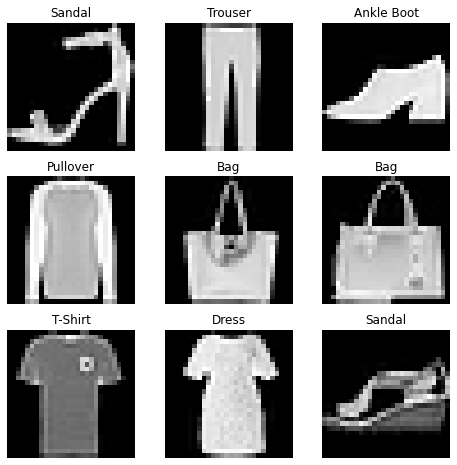

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Размер батча с фичами: torch.Size([256, 1, 28, 28])
Размер батча с метками: torch.Size([256])


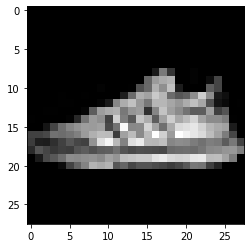

Метка: Sneaker


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Размер батча с фичами: {train_features.size()}")
print(f"Размер батча с метками: {train_labels.size()}")
img = train_features[0].squeeze()
label = labels_map[train_labels[0].item()]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Метка: {label}")

## GPU TEST

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## СТРОИМ МОДЕЛЬ (без batchnorm и dropout)

In [19]:
class NeuralNetwork(nn.Module):
    def __init__(self, lr=learning_rate, l2=l2):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

print("Структура модели: ", model, "\n\n")

# for name, param in model.named_parameters():
#     print(f"Слой: {name} | Размер: {param.size()} | Значения : {param[:2]} \n")

Структура модели:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
) 




In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2)
train_log = []
test_log = []

In [21]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_log.append(loss)        


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y).item()
            test_loss += loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_log.append((loss, correct))

    test_loss /= size
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Готово!")

Эпоха 1
-------------------------------
loss: 2.308989  [    0/60000]
loss: 1.013141  [25600/60000]
loss: 0.708763  [51200/60000]
Test Error: 
 Accuracy: 73.3%, Avg loss: 0.002846 

Эпоха 2
-------------------------------
loss: 0.653847  [    0/60000]
loss: 0.652499  [25600/60000]
loss: 0.526533  [51200/60000]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.002547 

Эпоха 3
-------------------------------
loss: 0.603550  [    0/60000]
loss: 0.499662  [25600/60000]
loss: 0.535003  [51200/60000]
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.002133 

Эпоха 4
-------------------------------
loss: 0.539181  [    0/60000]
loss: 0.427116  [25600/60000]
loss: 0.396285  [51200/60000]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.001967 

Эпоха 5
-------------------------------
loss: 0.507141  [    0/60000]
loss: 0.539851  [25600/60000]
loss: 0.373377  [51200/60000]
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.002048 

Эпоха 6
-------------------------------
loss: 0.481314  [    0/60000]
loss: 0.434172  [256

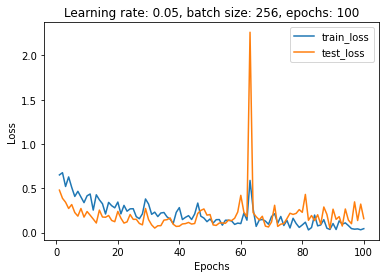

In [23]:
plt.plot(range(1, len(train_log)+1), train_log, label='train_loss')
plt.plot(range(1, len(test_log)+1), [i[0] for i in test_log], label='test_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Learning rate: {learning_rate}, batch size: {batch_size}, epochs: {epochs}')
plt.legend()
plt.show();

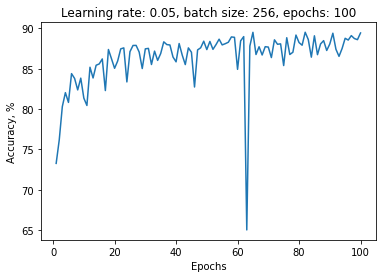

In [24]:
plt.clf()
plt.plot(range(1, len(test_log)+1), [i[1]/100 for i in test_log], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy, %')
plt.title(f'Learning rate: {learning_rate}, batch size: {batch_size}, epochs: {epochs}')
plt.show();